# Bounding boxes

In [1]:
#load datasets
import geopandas as gpd
import pandas as pd
#ADD './join-datasets/' to the path
import sys
sys.path.append('../join-datasets/')
from constants import loading_dict, temporal_buffer, ddataset_profile, ddisturbance_profile, DCLASS_SCORE, dtypes, doa, dsbuffer

ddataset = {dataset_name : gpd.read_parquet(dataset_path) for dataset_name, dataset_path in loading_dict.items()}

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#preprocessing bdiff:

ddataset['firepolygons']['class'] = 'Fire'
#add end date with offset of 7 days 
ddataset['firepolygons']['end_date'] = pd.to_datetime(ddataset['firepolygons']['start_date']) + pd.to_timedelta(7, unit='d')

ddataset['bdiff']['class'] = 'Fire'
ddataset['bdiff'] = ddataset['bdiff'][ ddataset['bdiff'].forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


ddataset['bdiff'][['start_date', 'end_date']] = ddataset['bdiff'].apply(to_datetime_safe, axis=1, result_type='expand')

#autoreload 
from attribution2 import Attribution
attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)

dataset bdiff is of spatial entity type
-> 95% of the areas are below : 127.49 km2, median : 27.37 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 124.78 km2, median : 24.99 km2


## Preprocessing

loading disturbances, clusters and communities

In [2]:
#load communities 
mode = 'equal'
resolution = 100
dim = 2
temporal_threshold_ = 180 * 2
spatial_threshold_  = 600

all_disturbances = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")

#filter disturbances by date 
#end_date should be greater than 2015 and and start_date should be less than 2020 
all_disturbances = all_disturbances[all_disturbances.end_date.dt.year >= 2017]
all_disturbances = all_disturbances[all_disturbances.start_date.dt.year <= 2020]

all_disturbances.rename(columns={'cluster':'community'}, inplace=True)

#dissolve by 'cluster'
communities = all_disturbances.dissolve(by='community', aggfunc='first')

In [3]:
method = 'HDBSCAN'
clusters = gpd.read_parquet(f"../data/results/clusters/clusters_{method}_m{mode}_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")
#reindex and called previous index 'cluster'
clusters = clusters.reset_index().rename(columns={'index':'cluster'})

#filter clusters by date, End_date year should be greater than 2017 and Start_Date year should be less than 2020
clusters = clusters[clusters.End_Date.dt.year >= 2017]
clusters = clusters[clusters.Start_Date.dt.year <= 2020]

#get unique id for cluster +mcommunity 
clusters = clusters.reindex().rename(columns={'index':'cluster'})

In [4]:
gdf_polygons = gpd.read_parquet(f"../data/results/clusters/clusters_polygons_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")

In [5]:
clusters_dissolved = gpd.read_parquet(f"../data/results/clusters/clusters_dissolved_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")


In [52]:
gdf_final_samples = gpd.read_parquet(f'../data/results/clusters/samples_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet')
#remove row with empty polygon
gdf_final_samples = gdf_final_samples[gdf_final_samples.geometry.is_empty == False]

# Run

In [89]:
import pandas as pd

# Assuming gdf_final_samples is your DataFrame and it already exists

# Step 1: Calculate the frequency of each cluster_class
class_counts = gdf_final_samples['cluster_class'].value_counts(ascending=True)

# Step 2: Define the custom order based on frequency (least to most common)
custom_order = class_counts.index.tolist()

# Step 3: Convert cluster_class to a categorical type with the custom order
gdf_final_samples['cluster_class'] = pd.Categorical(gdf_final_samples['cluster_class'], categories=custom_order, ordered=True)

# Step 4: Sort the DataFrame
gdf_final_samples_sorted = gdf_final_samples.sort_values(by='cluster_class')

# Now gdf_final_samples_sorted is sorted as desired
gdf_final_samples_sorted


,cluster,geometry,id,start_date,end_date,class,dataset,tree_type,essence,centroid_date,community,cluster_class,start_date_cluster,end_date_cluster,STR_cluster,TTR_cluster,IS_cluster,greco,conserved_for_sampling
0,75920,"MULTIPOINT (940581.656 6549944.770, 940643.172...",42972,2018-01-01,2018-12-31,Drought-dieback,hm,broadleaf,Beech,2018-07-02 00:00:00,9606,drought-dieback,2018-02-11,2018-11-18,0.637616,0.992196,0.611242,E,False
4,40912,"MULTIPOINT (968788.638 6697056.686, 969237.091...",36968,2017-01-01,2017-12-31,Drought-dieback,hm,conifer,Larches,2017-07-02 00:00:00,4431,drought-dieback,2017-07-02,2018-07-15,0.520768,0.970624,0.511297,E,False
3,3873,"MULTIPOINT (476908.791 6693981.408, 477419.838...",36979,2017-01-01,2017-12-31,Drought-dieback,hm,conifer,Pines,2017-07-02 00:00:00,403,drought-dieback,2018-07-01,2019-11-03,0.502197,0.815276,0.318748,B,False
2,88607,"MULTIPOINT (497073.099 6685102.976, 497256.895...",48531,2019-01-01,2019-12-31,Drought-dieback,hm,broadleaf,Oaks,2019-07-02 00:00:00,11309,drought-dieback,2019-02-10,2019-11-17,0.504844,0.992127,0.155089,B,False
17,235397,"MULTIPOINT (691972.153 6792155.860, 692308.170...",52242,2020-01-01,2020-12-31,Drought-dieback,hm,conifer,Firs,2020-07-01 12:00:00,29149,drought-dieback,2019-06-30,2020-07-12,0.553935,0.771038,0.358846,B,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,152817,"MULTIPOLYGON (((818514.824 6369368.045, 818544...",4834933,2020-01-01,2020-12-31,"Storm,Biotic",senfseidl,Broadleaf,broadleaf,2020-07-01 12:00:00,17467,storm,2020-02-09,2020-11-15,0.825591,0.981380,0.207581,J,True
1,125253,"MULTIPOLYGON (((1222212.708 6190297.011, 12222...",1735834,2017-01-01,2017-12-31,"Storm,Biotic",senfseidl,Broadleaf,broadleaf,2017-07-02 00:00:00,14729,storm,2017-02-12,2017-11-19,0.912899,0.982014,0.634168,K,True
30,125708,"MULTIPOLYGON (((831075.629 6391466.808, 831105...",1722572,2017-01-01,2017-12-31,"Storm,Biotic",senfseidl,Broadleaf,broadleaf,2017-07-02 00:00:00,14775,storm,2017-02-12,2017-11-19,0.903051,0.982014,0.688963,J,True
166,162278,"MULTIPOLYGON (((977976.976 6552932.250, 978006...",4232333,2019-01-01,2019-12-31,"Storm,Biotic",senfseidl,Broadleaf,beech,2019-07-02 00:00:00,18601,storm,2019-02-10,2019-11-17,0.951825,0.981701,0.581528,H,False


In [206]:
#remove row with empty polygon
clusters_dissolved = clusters_dissolved[clusters_dissolved.geometry.is_empty == False]
all_disturbances = all_disturbances[all_disturbances.geometry.is_empty == False]

import geopandas as gpd
import pandas as pd
from shapely.geometry import box

# Assuming fit_bbox is already defined as provided

def calculate_iou(s2_bbox, geom_bbox):
    intersection = s2_bbox.intersection(geom_bbox).area
    union = s2_bbox.union(geom_bbox).area
    return intersection / union if union != 0 else 0

import shapely 
from shapely.geometry import box 
def fit_bbox(geom : shapely.geometry.Polygon, lowlevelgroups : gpd.GeoDataFrame, c=3) -> shapely.geometry.Polygon:
    S2_bbox = geom.centroid.buffer(5000, cap_style=3) 
    Group_bbox = box(*geom.bounds)
    #if S2_bbox entirely contains Group_bbox, return S2_bbox
    if S2_bbox.contains(Group_bbox) or c == 0 or len(lowlevelgroups) == 0:
        return S2_bbox
    else : 
        #find row in lowlevelgroups that have the centroid the most far away from the centroid of the group
        centroid = geom.centroid
        lowlevelgroups['distance'] = lowlevelgroups.geometry.centroid.distance(centroid)
        #set distance to 0 for the row in lowlevelgroups that have False in the 'remove_allowed' column
        lowlevelgroups.loc[lowlevelgroups.remove_allowed == False, 'distance'] = 0
        row = lowlevelgroups.loc[lowlevelgroups['distance'].idxmax()]
        #drop this row
        return fit_bbox(geom, lowlevelgroups.drop(row.name), c-1)


#put cluster_s2 bbox and group_bbox and community_bbox in a geodataframe
import matplotlib.pyplot as plt 
def plot(list_bbox):
    names = ['cluster_s2_bbox', 'community_s2_bbox', 'cluster_bbox', 'community_bbox']
    bboxes = gpd.GeoDataFrame({'geometry':list_bbox, 'names':names}, geometry='geometry', crs='EPSG:2154')
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    bboxes.plot(ax=ax, column='names', alpha=0.25, legend=True, label='names')
    ax.set_axis_off()
    plt.show()
    return fig 

from tqdm import tqdm 
sampled_bboxes = []
clusters_dissolved_sampling = clusters_dissolved.copy()
all_disturbances_sampling = all_disturbances.copy()
conserved_for_sampling = []
start_dates = []
end_dates = []
for i, cluster_row in tqdm(gdf_final_samples_sorted.iterrows()):
    cluster_id = cluster_row['cluster']
    start_dates.append(cluster_row['start_date'])
    end_dates.append(cluster_row['end_date'])
    if len(clusters_dissolved_sampling.loc[clusters_dissolved_sampling['cluster'] == cluster_id]) > 0:
        cluster_geom = clusters_dissolved_sampling.loc[clusters_dissolved_sampling['cluster'] == cluster_id].geometry.iloc[0]
        community_id = clusters_dissolved_sampling.loc[clusters_dissolved_sampling['cluster'] == cluster_id, 'community'].iloc[0]
        community_geom = all_disturbances_sampling.loc[all_disturbances_sampling['community'] == community_id].geometry.unary_union
        
        cluster_s2_bbox = cluster_geom.centroid.buffer(5000, cap_style=3)
        community_s2_bbox = community_geom.centroid.buffer(5000, cap_style=3)
        cluster_bbox = box(*cluster_geom.bounds)
        community_bbox = box(*community_geom.bounds)
        
        iou1 = calculate_iou(cluster_s2_bbox, cluster_bbox)
        iou2 = calculate_iou(community_s2_bbox, community_bbox)

        # fig = plot([cluster_s2_bbox, community_s2_bbox, cluster_bbox, community_bbox])
        
        if iou2 == 1:
            bbox = community_s2_bbox
        elif iou1 == 1 and iou2 < 1:
            com = clusters_dissolved_sampling[clusters_dissolved_sampling['community'] == community_id]
            #add column 'remove_allowed'==False to com if cluster = cluster_id else true
            com['remove_allowed'] = com['cluster'] != cluster_id
            bbox = fit_bbox(community_geom, clusters_dissolved_sampling[clusters_dissolved_sampling['community'] == community_id])
        elif iou1 < 1:
            disturbances_in_cluster = all_disturbances_sampling[all_disturbances_sampling['community'] == community_id]
            disturbances_in_cluster['remove_allowed'] = True
            #first row = False
            disturbances_in_cluster.loc[disturbances_in_cluster.index[0], 'remove_allowed'] = False
            bbox = fit_bbox(cluster_geom, disturbances_in_cluster)
        else :
            bbox = None
        
        if bbox is not None:
            conserved_for_sampling.append(True)
            
            sampled_bboxes.append(bbox)
            #remove cluster from clusters_dissolved that intersect the bbox
            clusters_dissolved_sampling = clusters_dissolved_sampling[~clusters_dissolved_sampling.intersects(bbox)]
            #same for disturbances
            all_disturbances_sampling = all_disturbances_sampling[~all_disturbances_sampling.intersects(bbox)]
        else :
            conserved_for_sampling.append(False)
    else :
        conserved_for_sampling.append(False)
    


gdf_final_samples['conserved_for_sampling'] = conserved_for_sampling
gdf_final_samples['start_date'] = start_dates
gdf_final_samples['end_date'] = end_dates

603it [01:22,  7.27it/s]


In [207]:
gdf_final_samples['start_date'] = start_dates
gdf_final_samples['end_date'] = end_dates

<Axes: >

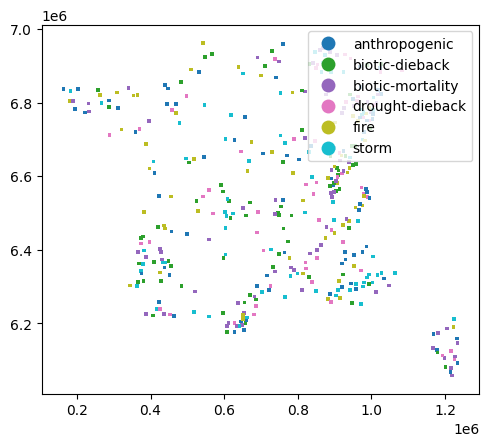

In [208]:
#put sampled bbox in a geodataframes
gdf_sampled_bbox = gpd.GeoDataFrame(geometry=sampled_bboxes, crs='EPSG:2154')
gdf_sampled_bbox['main_cluster_class'] = gdf_final_samples[gdf_final_samples['conserved_for_sampling'] == True]['cluster_class'].tolist()
gdf_sampled_bbox['start_date'] = gdf_final_samples[gdf_final_samples['conserved_for_sampling'] == True]['start_date'].tolist()
gdf_sampled_bbox['end_date'] = gdf_final_samples[gdf_final_samples['conserved_for_sampling'] == True]['end_date'].tolist()
gdf_sampled_bbox.plot(column='main_cluster_class', legend=True)

In [209]:
#add Indexes to cluster_dissolved based on a join with clusters
list_features = []
for i, row_ in tqdm(enumerate(gdf_sampled_bbox.itertuples())):
    
    #intersection with all_disturbances
    intersection_disturbances = gdf_polygons[gdf_polygons.geometry.intersects(row_.geometry)]
    
    for j, row in enumerate(intersection_disturbances.itertuples()):
        list_features.append({'bbox':i, 
                              'disturbance':j, 
                              'cluster':row.cluster,
                              'community': row.community,
                              'dataset':row.dataset,
                              'cluster_class': row.cluster_class, 
                              'start_date':row.start_date, 
                              'end_date': row.end_date,
                              'tree_type': row.tree_type,
                              'essence': row.essence, 
                              'geometry':row.geometry})


#build geodataframe from list_features
gdf_features= gpd.GeoDataFrame(list_features, geometry='geometry', crs='EPSG:2154')

399it [00:13, 30.32it/s]


In [ ]:
import geopandas as gpd
from shapely.geometry import box

# Compute pairwise intersections and calculate total intersection area
total_intersection_area = 0
for i, geom1 in tqdm(enumerate(gdf_sampled_bbox.geometry)):
    for j, geom2 in enumerate(gdf_sampled_bbox.geometry):
        if i >= j:  # Avoid repeating comparisons
            continue
        intersection = geom1.intersection(geom2)
        total_intersection_area += intersection.area

# Calculate total area of all geometries
total_area = gdf_sampled_bbox.geometry.area.sum()

# Compute percentage overlap
percentage_overlap = (total_intersection_area / total_area) 

print(f"Percentage of Overlapping: {percentage_overlap:.2%}")


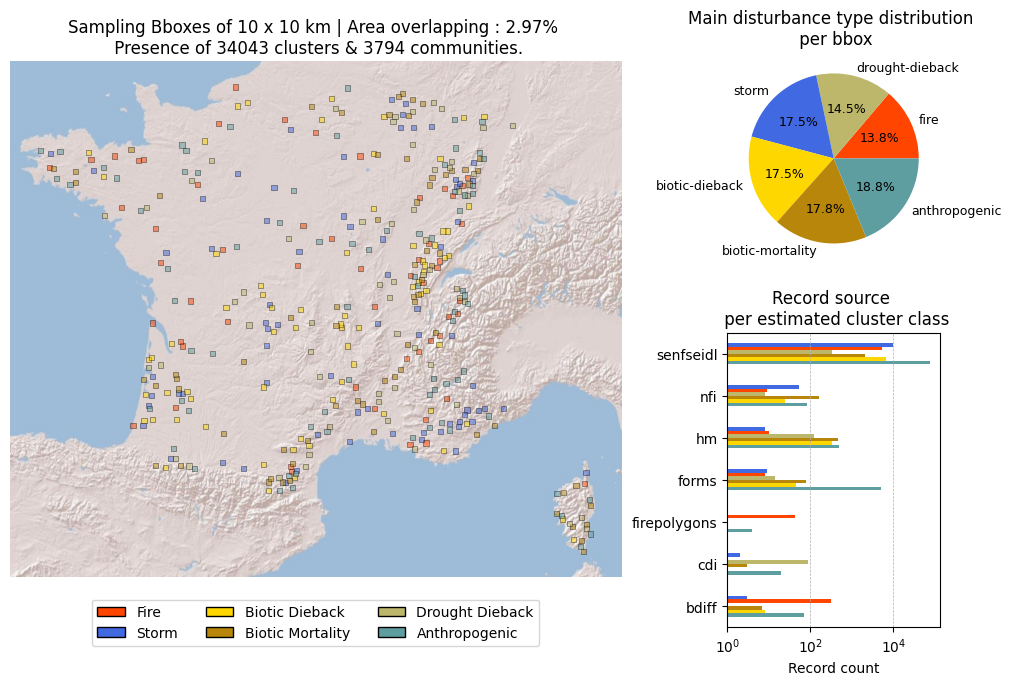

In [210]:
#create a 8x12 grid with one main plot of 8x8 and two plot of 4x4 on the right with gridspec
alpha=0.5
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(8, 12, wspace=0.5, hspace=0.5)  # Adjusted spacing
custom_color_mapping = {
    'fire': 'orangered',
    'storm': 'royalblue',
    'biotic-dieback': 'gold',
    'biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'drought-dieback': 'darkkhaki',
    'anthropogenic': 'cadetblue'  # Light blue/grey
}
ax_main = plt.subplot(gs[:, :8])
ax_pie1 = plt.subplot(gs[:4, 9:])  # Adjusted for spacing
ax_pie2 = plt.subplot(gs[4:, 9:]) 

#AX_MAIN
ax = ax_main
for disturbance, color in custom_color_mapping.items():
    gdf_sampled_bbox[gdf_sampled_bbox['main_cluster_class'] == disturbance].plot(ax=ax, color=color, alpha=alpha, edgecolor='black', linewidth=0.5)
ax.set_title('Sampling Bboxes of 10 x 10 km | Area overlapping : {:.2%} \n Presence of {} clusters & {} communities.'.format(percentage_overlap,gdf_features.cluster.nunique(), gdf_features.community.nunique() ))
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldShadedRelief, crs='EPSG:2154', attribution=False)
#construct custom legend with patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor='orangered', edgecolor='black', label='Fire'),
                   Patch(facecolor='royalblue', edgecolor='black', label='Storm'),
                   Patch(facecolor='gold', edgecolor='black', label='Biotic Dieback'),
                   Patch(facecolor='darkgoldenrod', edgecolor='black', label='Biotic Mortality'),
                   Patch(facecolor='darkkhaki', edgecolor='black', label='Drought Dieback'),
                   Patch(facecolor='cadetblue', edgecolor='black', label='Anthropogenic')]
#add legend below and outside ax_main
ax_main.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.03), ncol=3, fontsize=10)

#AX_PIE1
ax = ax_pie1
class_counts = gdf_final_samples[ gdf_final_samples['conserved_for_sampling'] == True]['cluster_class'].value_counts(ascending=True)
# Step 2: Define the custom order based on frequency (least to most common)
custom_order = class_counts.index.tolist()
#add percentage on the figure in white and with the custom_color_mapping
gdf_final_samples[ gdf_final_samples['conserved_for_sampling'] == True].cluster_class.value_counts(ascending=True).plot.pie(ax=ax, autopct='%1.1f%%', 
                                                                                                              colors=[custom_color_mapping.get(x, 'grey') for x in custom_order],
                                                                                                              textprops={'fontsize':9})
ax.set_title('Main disturbance type distribution \n per bbox')
#remove count label
ax.set_ylabel('')

#AX_PIE2
ax = ax_pie2
gdf_features.groupby('dataset')['cluster_class'].value_counts(ascending=False).unstack().plot(kind='barh', stacked=False, ax=ax, color=custom_color_mapping, log=True)
#change fontsize of the legend
ax.set_title('Record source \n per estimated cluster class', fontsize=12)
ax.set_ylabel('')
ax.grid(axis='x', linestyle='--', linewidth=0.5)
ax.set_xlabel('Record count')
#remove any legend
ax.get_legend().remove()

fig.tight_layout()
fig.savefig('../figures/ARTICLE_sampling_bbox.png', dpi=300, bbox_inches='tight')


In [193]:
gdf_features['centroid_date'] = (gdf_features['start_date'] + (gdf_features['end_date'] - gdf_features['start_date'])/2).dt.year

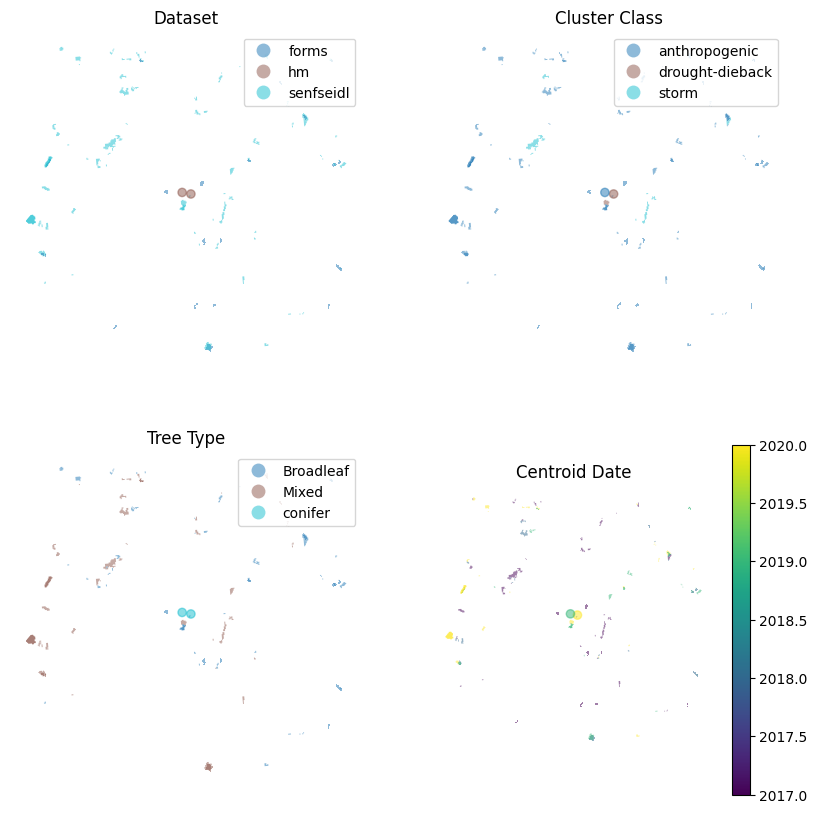

In [197]:

index = 0

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()
gdf_features[ gdf_features['bbox'] == index].plot(column='dataset', legend=True, alpha=0.5, ax=axes[0])
gdf_features[ gdf_features['bbox'] == index].plot(column='cluster_class', legend=True, alpha=0.5, ax=axes[1])
gdf_features[ gdf_features['bbox'] == index].plot(column='tree_type', legend=True, alpha=0.5, ax=axes[2])
gdf_features[ gdf_features['bbox'] == index].plot(column='centroid_date', legend=True, alpha=0.5, ax=axes[3])
names = ['Dataset', 'Cluster Class', 'Tree Type', 'Centroid Date']
for ax in axes:
    ax.set_axis_off()
    ax.set_title(names.pop(0))

In [211]:
import os
os.makedirs('../data/results/sampling', exist_ok=True)
gdf_sampled_bbox.to_parquet('../data/results/sampling/sampled_bboxes.parquet')
gdf_features.to_parquet('../data/results/sampling/sampled_features.parquet')


In [203]:
gdf_features

,bbox,disturbance,cluster,community,dataset,cluster_class,start_date,end_date,tree_type,essence,geometry,centroid_date
0,0,0,25602,2741,senfseidl,anthropogenic,2018-01-01,2018-12-31,Mixed,mixed,"POLYGON ((621497.270 6763845.439, 621527.133 6...",2018
1,0,1,25602,2741,senfseidl,anthropogenic,2018-01-01,2018-12-31,Mixed,mixed,"POLYGON ((621461.852 6763902.239, 621491.716 6...",2018
2,0,2,25603,2741,senfseidl,anthropogenic,2018-01-01,2018-12-31,Mixed,mixed,"POLYGON ((621399.349 6763926.340, 621429.212 6...",2018
3,0,3,25603,2741,senfseidl,anthropogenic,2018-01-01,2018-12-31,Mixed,mixed,"POLYGON ((621369.485 6763923.474, 621366.708 6...",2018
4,0,4,25604,2741,forms,anthropogenic,2017-09-01,2018-05-01,Mixed,mixed,"POLYGON ((621650.159 6763798.901, 621660.159 6...",2017
...,...,...,...,...,...,...,...,...,...,...,...,...
107812,398,622,231722,28556,senfseidl,fire,2018-01-01,2018-12-31,Mixed,broadleaf,"POLYGON ((1225300.770 6192085.518, 1225241.120...",2018
107813,398,623,231723,28556,senfseidl,storm,2018-01-01,2018-12-31,Broadleaf,broadleaf,"POLYGON ((1226025.599 6191030.855, 1226085.250...",2018
107814,398,624,231723,28556,senfseidl,storm,2018-01-01,2018-12-31,Broadleaf,broadleaf,"POLYGON ((1226494.821 6191163.516, 1226554.472...",2018
107815,398,625,231723,28556,senfseidl,storm,2018-01-01,2018-12-31,Mixed,broadleaf,"POLYGON ((1224941.232 6191055.036, 1224935.908...",2018
